# Introduction
Contests have become a very popular way to develop new algorithms. The basic idea is to give a large group of people (participants) access to exactly the same training data and testing data.
### Training Data
The training data has some input and the desired output. In the case of this example the input is an image and the output is the identification of the number which is inside the image. In the case of the 2017 Kaggle Data Science Bowl this is a Chest CT of a person and the output is a 1 or 0 if they have cancer or not. The training data is then used to build a number of different tools to solve the problem.
### Testing Data
The testing data are also made up of inputs and desired outputs, but the participants are just given the inputs (in this case just the images) upon which the different algorithms can be tested. Each participant submits their predictions or guesses for the ouputs to the organizer who can then compare the guesses with the known outputs. The algorithm which _matches_ the most wins (there are many different criteria for choosing the best, but in this case we will just count matches).

### Standard Imports
Here we just import some of the standard functions we will need later

In [2]:
from __future__ import print_function, division
import numpy as np
import matplotlib.pyplot as plt
import os # for operating system commands like dealing with paths
DATA_PATH = 'F:/Uni_ETH/0_QBI/Data~' # where are the test.csv and train.csv files located
test_data_path = os.path.join(DATA_PATH, 'test.csv')
train_data_path = os.path.join(DATA_PATH, 'train.csv')

Load the training data from the file. Since we know the first column is the 'label' of the number we extract that from the rest and reform the remaining columns as a 28x28 array

In [3]:
%%time
# this takes around 30 seconds so be patient
train_data = np.loadtxt(train_data_path, delimiter = ',', skiprows = 1)
numb_id = train_data[:,0] # just the number id
numb_vec = train_data[:,1:] # the array of the images

Wall time: 1min 9s


In [4]:
print('Input Data:', train_data.shape)
print('Number ID:', numb_id.shape)
print('Number Vector:', numb_vec.shape)

Input Data: (42000, 785)
Number ID: (42000,)
Number Vector: (42000, 784)


The image is formatted as a vector (a single long array), we want to reshape it to look like an image

In [5]:
numb_image = numb_vec.reshape(-1, 28, 28)
print('Number Image', numb_image.shape)

Number Image (42000, 28, 28)


Now we can show the image to make sure it is reasonable

(-0.5, 27.5, 27.5, -0.5)

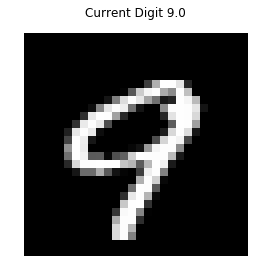

In [6]:
%matplotlib inline
fig, ax1 = plt.subplots(1,1)
ax1.matshow(numb_image[100], cmap = 'gray')
ax1.set_title('Current Digit {}'.format(numb_id[100]))
ax1.axis('off')

# Building a Classifier
Since we haven't covered any of the machine learning approaches yet, we will focus on a very simple classifier. Here we will use the MSE and SSIM that we learned about last lecture in order to take a given image and see what image it is most similar to. For this rather than taking the whole image set, we will just take one example of each number (hopefully it is a good example)
## Getting Examples

In [72]:
from scipy.ndimage.filters import gaussian_filter
current_filter = lambda img: gaussian_filter(img, sigma = (1, 1), order = (0, 0), mode = 'reflect')

In [73]:
digit_examples = {} # we use a dictionary to store the results
for cur_digit in np.unique(numb_id):
    # find the first example
    digit_matches = np.where(numb_id == cur_digit)
    digit_examples[cur_digit] = current_filter(numb_image[digit_matches[0][0]])

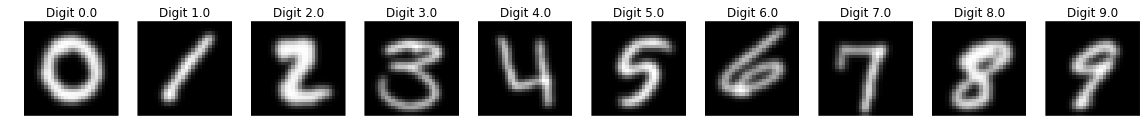

In [74]:
fig, c_axs = plt.subplots(1, len(digit_examples), figsize = (20, 3))
for c_ax, (c_digit, c_img) in zip(c_axs, digit_examples.items()):
    c_ax.imshow(c_img, cmap = 'gray', interpolation = 'none')
    c_ax.set_title('Digit {}'.format(c_digit))
    c_ax.axis('off')

### Obtain Test Data

In [5]:
%%time
test_vec = np.loadtxt(test_data_path, delimiter = ',', skiprows = 1)
print('Test Vec', test_vec.shape)
test_image = test_vec.reshape(-1, 28, 28)
print('Test Image', test_image.shape)

Test Vec (28000, 784)
Test Image (28000, 28, 28)
Wall time: 47.5 s


### Build the Classifier #1
Using the dictionary of example digits we can build a very simple classifier using the MSE to find the best match

In [65]:
def mse(img1, img2):
    return np.mean(np.power(img1-img2,2))

from skimage.measure import compare_ssim as ssim # structural similarity

In [66]:
def classify_image(example_dict, in_image):
    score_dict = {c_digit: ssim(in_image, c_img) for c_digit, c_img in example_dict.items()}
    # For SSIM you sort with reverse = True
    best_digit, best_score = sorted(score_dict.items(), 
                                    key = lambda x: x[1], reverse = True)[0] # sort by score and take the first item
    return best_digit, score_dict

Guessed 2.0, actual result was 1.0
Score for other numbers: {0.0: -0.021762165093652301, 1.0: 0.084752505421324439, 2.0: 0.1568919889037001, 3.0: 0.028314160477971511, 4.0: -0.04221010433930681, 5.0: 0.084527288828559644, 6.0: 0.029603555306218315, 7.0: 0.10132093189853725, 8.0: 0.14132104999148043, 9.0: 0.083373803877080793}


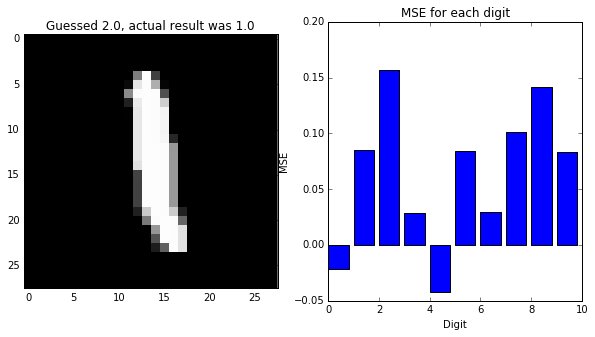

In [71]:
rand_digit = np.random.choice(range(len(numb_image))) # just picks a random digit
def guess_idx(digit_idx):
    guess_digit, guess_dict = classify_image(digit_examples, numb_image[digit_idx])
    print('Guessed {}, actual result was {}'.format(guess_digit, numb_id[digit_idx]))
    print('Score for other numbers:', guess_dict)
    # show the results
    fig, (ax_img, ax_score) = plt.subplots(1,2, figsize = (10, 5))
    ax_img.imshow(numb_image[rand_digit], cmap = 'gray', interpolation = 'none')
    ax_img.set_title('Guessed {}, actual result was {}'.format(guess_digit, numb_id[digit_idx]))
    ax_score.bar(guess_dict.keys(), guess_dict.values())
    ax_score.set_xlabel('Digit')
    ax_score.set_ylabel('MSE')
    ax_score.set_title('MSE for each digit')

guess_idx(rand_digit)

### Build the Classifier #2
use more elaborate model


In [6]:
%%time
from sklearn.svm import SVC
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.utils import shuffle
from sklearn.decomposition import PCA
# numb_vec, numb_id, test_vec

rnd_state = np.random.randint(0,128**2)
numb_vecS, numb_idS = shuffle(numb_vec, numb_id, random_state = rnd_state)

scaler = StandardScaler().fit(numb_vecS)
trainData = scaler.transform(numb_vecS)
pca = PCA().fit(trainData)
trainData = pca.transform(trainData)

Wall time: 1min 28s


In [ ]:
%%time
testData = scaler.transform(test_vec)
testData = pca.transform(testData)

svc = SVC(C = 1, gamma = 1/trainData.shape[1])
svc.fit(trainData, numb_idS)
pred_id = svc.predict(testData)

In [ ]:
123

# Submitting an Entry
We can now submit an entry to the contest by running our digit classifier on all of the test images. The data for the test images is the same as the training data but there are no labels.

## Make a guess for each image
Here we make a guess for each image by using our ```classify_image``` function and just keeping the first result (the digit) and not the entire dictionary

In [51]:
%%time
guess_test_data = [classify_image(digit_examples, c_img)[0] for c_img in test_image]

Wall time: 2min 35s


### Save the results
Here we save the results to a file called submission that we can upload to Kaggle and see how we perform

In [52]:
with open('submission.csv', 'w') as out_file:
    out_file.write('ImageId,Label\n')
    # for img_id, guess_label in enumerate(guess_test_data):
    for img_id, guess_label in enumerate(pred_id):
        out_file.write('%d,%d\n' % (img_id+1, guess_label))

# Basic Tasks
- Submit the output to the competition, where does it come in? Is this better or worse than expected? What would random guessing be?

# Idea Questions
- What causes the classifier to fail on certain images?
- How could the classifier be improved?
- Could filtering or image enhancement improve the result, if so how

# Challenge Tasks
- Try improving the classifier by using SSIM or another similarity metric.
- Try using more examples (or better examples)
- Implement a version using image enhancement and compare the results

# Building a Classifier _ Enhanced
Here we try to construct a more powerful classifer using what is already available

In [ ]:
from sklearn.svm import SVC
classifier = SVC(C = 1, gamma = 0.001)
classifier.fit(numb_vec, numb_id)
predicted = classifier.predict(test_vec)

In [4]:
import tensorflow as tf
# create image placeholder
x = tf.placeholder(tf.float32, [None, 784])

# Variables to learn 
W = tf.Variable(tf.zeros([784, 10]))
b = tf.Variable(tf.zeros([10]))

# define model
y = tf.nn.softmax(tf.matmul(x, W) + b)

#
y_ = tf.placeholder(tf.float32, [None, 10])

# Implement cross entropy
cross_entropy = tf.reduce_mean(-tf.reduce_sum(y_ * tf.log(y), reduction_indices=[1]))
# Train by minimizng a function
train_step = tf.train.GradientDescentOptimizer(0.5).minimize(cross_entropy)

In [ ]:
sess = tf.InteractiveSession()
tf.global_variables_initializer().run()
for _ in range(1000):
  batch_xs, batch_ys = mnist.train.next_batch(100)
  sess.run(train_step, feed_dict={x: batch_xs, y_: batch_ys})

In [33]:
with open('submission_new.csv', 'w') as out_file:
    out_file.write('ImageId,Label\n')
    for img_id, guess_label in enumerate(predicted):
        out_file.write('%d,%d\n' % (img_id+1, guess_label))

NameError: name 'predicted' is not defined